# Métodos conservativos

Resolvemos la ecuación de Burgers (y la ecuación de advección) usando el método KT2 (Kurganov_Tadmor de orden 2) y MP5 (monotonicity preserving 5).

In [1]:
#using DiffEqOperators
using OrdinaryDiffEq
#using DifferentialEquations

In [2]:
using Plots
using Printf

Aquí decidimos la ecuación a resolver. Esto será utilizado a la hora de elegir la función `Flux_x!` más adelante.

In [3]:
#problem = :advection
problem = :burgers

:burgers

Incluimos las implementaciones numéricas de los métodos junto con algunas funciones auxiliares

In [4]:
include("choques_utils.jl") # todas las funciones necesarias

wenoz! (generic function with 1 method)

Vamos a utilizar los métodos Kurganov-Tadmor, WENO-Z, y MP5

Definimos la velocidad máxima de propagación. Esto es necesario para ajustar la disipación del método, así como garantizar estabilidad. Lo que importa es tener una cota inferior para la velocidad máxima de propagación de ondas en cualquier punto.

In [5]:
#Velocidad máxima de propagación

function advectionspeed(U, c)
    return abs(c)
end

function burgersspeed(U, c)
    return maximum(abs, U) 
end

if problem == :advection
    SpeedMax = advectionspeed
elseif problem == :burgers
    SpeedMax = burgersspeed
end

burgersspeed (generic function with 1 method)

Aquí damos la función ```Flux_x!```. Recuerde que estamos resolviendo problemas del tipo 

$$ u_t = F(u)_x$$

In [6]:
#Flujos
function advection!(F, U, c)
    @. F = c*U
end

function burgers!(F, U, Fpars)
    @. F = 0.5*U*U
end

if problem == :advection
    Flux_x! = advection!
elseif problem == :burgers
    Flux_x! = burgers!
end

burgers! (generic function with 1 method)

Ahora empezamos a construir finalmente el problema. Primero definimos el intervalo espacial y temporal, junto con el vector donde guardaremos la solución. También elegimos algunos parámetros del problema.

In [7]:
N = 100
N_FIELDS = 1

start = 0.0
stop = 2.0*pi
x = range(start, stop =stop, length = N+1)[1:end-1] #de manera que no incluya el último punto
dx = Float64(x.step)  #Δx
h = 1.0/dx
#Inicializamos el dato
u = Array{Float64}(undef, N, N_FIELDS)
du = copy(u)
@. u[:,1] = 0.5 + sin(x)

#Definimos el intervalo de integración y el paso dt
T = 4.0
tspan = (0.0, T)

#CFL = dt/dx
CFL = 0.1
dt = dx * CFL

#Parámetros del problema
if problem == :advection
    eqpars = 1.0
elseif problem == :burgers
    eqpars = false
end

false

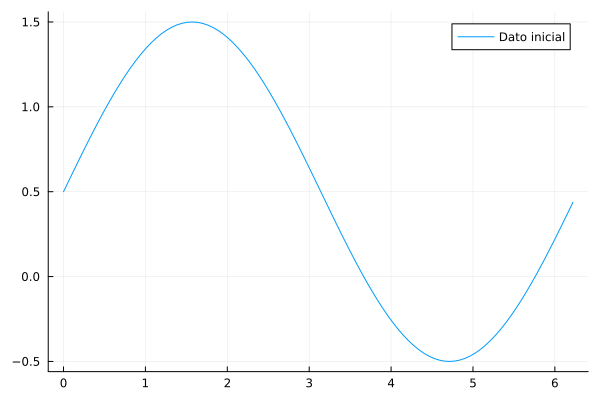

In [8]:
#Dato inicial
plot(x, u[:,1], label = "Dato inicial")

Aquí elegimos el método de resolucion espacial, y preparamos la tupla `par` para integrar más adelante. Varias de estas funciones están definidas en `choques_utils.jl`

In [9]:
#Listado de métodos a comparar
#KurganovTadmor
θ = 2.0  #Este valor tiene que estar entre 1 y 2. Mientras más cerca de 2, menor disipación.
         #Para sistemas de ecuaciones es mejor que esté más cerca de 1 para evitar oscilaciones.
auxvectorsKT = createKTauxvectors(N_FIELDS)
parKT = (eqpars, h, θ, Flux_x!, SpeedMax, N, N_FIELDS, auxvectorsKT)
#WENOZ
auxvectorsWENOZ = createWENOZvectors(N_FIELDS)
parWENOZ = (eqpars, h, N, N_FIELDS, Flux_x!, SpeedMax, auxvectorsWENOZ)
#MP5
auxvectorsMP5 = createMP5auxvectors(N_FIELDS)
parMP5 = (eqpars, h, N, N_FIELDS, Flux_x!, SpeedMax, auxvectorsMP5)


(false, 15.915494309189533, 100, 1, burgers!, burgersspeed, ([0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]))

La solución es una matriz de tamaño `N*N_Fields`. Para los problemas escalares esto quiere decir que son escencialmente un vector de una única columna, pero puede probar con sistemas de ecuaciones y funcionará igual.
Recuerde que para analizar convergencia es conveniente tomar datos iniciales que sean suaves y que sean polinómicos a trozos.

Ahora estamos en condiciones de definir los problemas, elegir integradores y fijar su comportamiento. Aquí es importante elegir un integrador estable, es decir uno cuya región de estabilidad incluya parte del eje imaginario, y preferentemente que sea TVD (Total Variation Diminishing). En nuestro caso eligiremos el integrador Runge Kutta `SSPRK33`, que es de tercer orden en el tiempo y es TVD.

In [10]:
probKT = ODEProblem(KT!,u,tspan,parKT);
probWENOZ = ODEProblem(wenoz!,u,tspan,parWENOZ);
probMP5 = ODEProblem(mp5!,u,tspan,parMP5);

In [11]:
solKT = solve(probKT,SSPRK33(),dt=dt, saveat = T/100); # Este es un método TVD

In [12]:
solWENOZ = solve(probWENOZ,SSPRK33(),dt=dt, saveat = T/100); # Este es un método TVD


In [13]:
solMP5 = solve(probMP5,SSPRK33(),dt=dt, saveat = T/100); # Este es un método TVD
#@benchmark sol = solve(prob,SSPRK33(),dt=dt, saveat = T/100) # Esto es un método TVD

retcode: Success
Interpolation: 1st order linear
t: 101-element Vector{Float64}:
 0.0
 0.04
 0.08
 0.12
 0.16
 0.2
 0.24
 0.28
 0.32
 0.36
 ⋮
 3.68
 3.72
 3.76
 3.8
 3.84
 3.88
 3.92
 3.96
 4.0
u: 101-element Vector{Matrix{Float64}}:
 [0.5; 0.5627905195293134; … ; 0.37466676643569535; 0.43720948047068675;;]
 [0.4807703606424982; 0.5411732697402934; … ; 0.360378791181918; 0.4204349294136941;;]
 [0.46297078807028946; 0.5211391309268804; … ; 0.3471644720523945; 0.40491850168092713;;]
 [0.44645144672349246; 0.5025284344775103; … ; 0.3349067835716579; 0.39052500263307977;;]
 [0.43108160429890346; 0.4852003270695959; … ; 0.32350490507993307; 0.37713737912125744;;]
 [0.4167470495575985; 0.469030659586065; … ; 0.31287164372467385; 0.3646540016443397;;]
 [0.4033476700400251; 0.4539098218656075; … ; 0.30293118822946785; 0.3529862312776979;;]
 [0.39079547968414013; 0.43974091066010923; … ; 0.293617344633723; 0.34205648232868857;;]
 [0.3790129671115611; 0.42643814344352404; … ; 0.28487210612726854

Una vez que tenemos la solución, podemos analizarla. Aquí mostramos cómo graficarla.

┌ Info: Saved animation to /Users/reula/Docencia/PDE/pde/2024/Numericos/Tarea_4/burgers_sin.gif
└ @ Plots /Users/reula/.julia/packages/Plots/sxUvK/src/animation.jl:156


Plots.AnimatedGif("/Users/reula/Docencia/PDE/pde/2024/Numericos/Tarea_4/burgers_sin.gif")
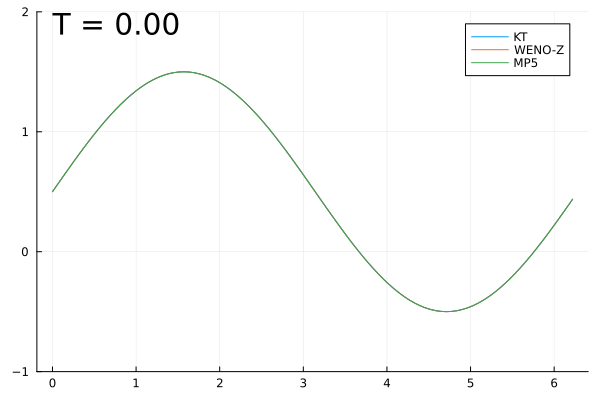

In [14]:

anim = @animate for t in solKT.t
    plt = plot(x, solKT(t), ylims = (-1.0,2.0), label = "KT")
    plot!(plt, x, solWENOZ(t), ylims = (-1.0,2.0), label = "WENO-Z")
    plot!(plt, x, solMP5(t), ylims = (-1.0,2.0), label = "MP5")
    annotate!(plt, 0.0, 1.9, text("T = $(@sprintf("%.2f", t))", :black, :left, 20))
end
gif(anim, "burgers_sin.gif", fps = 30)

### Ayuda para analizar convergencia en KT
Para los métodos MP5 y WENOZ puede analizar la covnergencia utilizando la norma $L_1$. Para el método de Kurganov-Tadmor, deberá utilizar la norma $Lip'$. Le daremos la implementación de esta norma y cómo utilizarla para calcular el factor $Q$.

In [16]:
function Lipprime(u, dx)
    pr = zeros(size(u)[1])
    for i in 2:size(u)[1]
        pr[i] = pr[i-1] + (u[i]+u[i-1])*dx
    end
    return sum(abs.(pr))*dx
end
function QKT(t, sol1, sol2, sol4, dx1, dx2)
    n1 = Lipprime(sol1(t)[:,1]-sol2(t)[1:2:end,1], dx1)
    n2 = Lipprime(sol2(t)[:,1]-sol4(t)[1:2:end,1], dx2)
    return log2(n1/n2)
end

QKT (generic function with 1 method)